## 1 Data preprocessing

In [1]:
import torch
from torchvision import transforms
from torchvision.io import read_image

def load_img(fname):
    """
    Load an image from file, do transformation (including possible augmentation) and return it as torch.tensor

    :param fname: path to jpg image
    """
    img = read_image(fname)
    x = img / 255.
    
    transform = transforms.Compose([
        transforms.Resize((218, 178)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return transform(x)

In [2]:
import pandas as pd

img_path = "../datasets/data"

train_features = pd.read_csv(f"{img_path}/train.csv")

train_features.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

There are a lot of features in the dataset, I'm choosing whether a person is wearing glasses or not.

In [3]:
img_path = "../datasets/images"

# Load and transform images 
images = torch.stack([load_img(f"{img_path}/train/{item['image_id']}") for _, item in  train_features.iterrows()])

# Select label(s) from train_features
labels = train_features['Eyeglasses']
# Leave values that only 1 or 0 and convert to float just for simplicity
labels.replace(-1, 0, inplace=True)
labels = torch.from_numpy(labels.to_numpy()).float()

In [4]:
images.shape, labels.shape

(torch.Size([11785, 3, 218, 178]), torch.Size([11785]))

## 2 Visualization

In [5]:
def reverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Reverse the normalization applied to the image tensor for display purposes.

    :param tensor: Normalized image tensor
    :param mean: Mean used for normalization
    :param std: Standard deviation used for normalization
    """
    mean = torch.tensor(mean).view(1, 1, 3)
    std = torch.tensor(std).view(1, 1, 3)
    return tensor * std + mean

In [6]:
import matplotlib.pyplot as plt


def plot_images(images, captions=[], rows=2, columns=5, title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        img = reverse_normalize(img)
        plt.imshow(img)
        if i < len(captions):
            plt.title(captions[i])
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

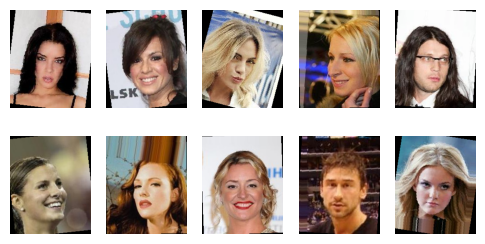

In [7]:
# Visualise 10 images from the dataset
plot_images(images[:10].permute((0, 2, 3, 1)), cmap="gray")

## 3 Data loaders creation

In [8]:
from torch.utils.data import TensorDataset, DataLoader

processed_dataset = TensorDataset(images, labels)

# Set proportion and split dataset into train and validation parts
proportion = 0.8

train_dataset, val_dataset = torch.utils.data.random_split(
    processed_dataset,
   [(int(len(images) * proportion)), len(images) - int(len(images) * proportion)],
)

In [9]:
# Create Dataloaders for training and validation 
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Testing DataLoader

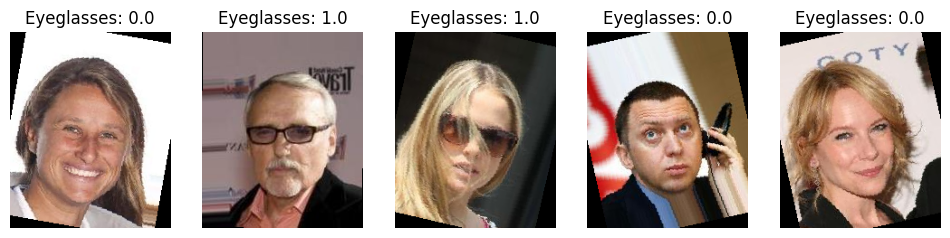

In [13]:
import matplotlib.pyplot as plt


for images, labels in train_loader:
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        ax = axes[i]

        img = images[i]
        img = img.permute(1, 2, 0)
        img = reverse_normalize(img)

        ax.imshow(img)
        ax.set_title(f'Eyeglasses: {labels[i].item()}')
        ax.axis('off')
    plt.show()
    break

## 4 Defining a model

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class CNNClassificationModel(nn.Module):
    """
    CNN (convolutional neural network) based classification mode
    """

    def __init__(self, num_classes=2):
        super(CNNClassificationModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.fc1 = nn.Linear(128 * 27 * 22, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 27 * 22)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## 5 Defining training & validation loops

In [17]:
from tqdm.notebook import tqdm

def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    writer=None,
    epochs=1,
    device='cpu',
    ckpt_path="../deployment/api/best.pt",
):
    # Best score for checkpointing
    best = 0.0
    # Counter for lowering the learning rate
    counter = 0

    model.to(device)
    
    # Iterating over epochs
    for epoch in range(epochs):

        model.train()
        train_loss = 0.0
        # Training loop description
        train_loop = tqdm(
            enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}"
        )
        # Iterate over dataset 
        for data in train_loop:
            # Move data to a device, do forward pass and loss calculation, do backward pass and run optimizer
            optimizer.zero_grad()
            
            index, (inputs, labels) = data
            inputs, labels = inputs.to(device), labels.to(device).long()
            
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            train_loss += loss.item()
            train_loop.set_postfix({"loss": loss.item()})
        
            loss.backward()
            optimizer.step()

        # Write loss to tensorboard
        if writer:
            writer.add_scalar("Loss/train", train_loss / len(train_loader), epoch)
        
        # Validation
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            model.eval()  # Evaluation mode
            val_loop = tqdm(enumerate(val_loader, 0), total=len(val_loader), desc="Val")
            for data in val_loop:
                index, (inputs, labels) = data
                # Get predictions and compare them with labels
                inputs, labels = inputs.to(device), labels.to(device).long()
                
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Calculate validation loss
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                val_loop.set_postfix({"acc": correct / total})

            val_accuracy = correct / total
            val_loss /= len(val_loader)
            
            # Save the checkpoint if accuracy is the best so far
            if val_accuracy > best:
                torch.save(model.state_dict(), ckpt_path)
                best = val_accuracy
                counter = 0
            # Load the best model and continue training with lower learning rate
            else:
                counter += 1
                if counter >= 3:
                    new_learning_rate = optimizer.param_groups[0]['lr'] * 0.25
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = new_learning_rate
                    print(f'Learning rate has been reduced to {new_learning_rate}')
                    counter = 0

                    ckpt = torch.load("../../models/best.pt", weights_only=True)
                    model.load_state_dict(ckpt)
        # Write loss and accuracy to tensorboard
        if writer:
            writer.add_scalar("Accuracy", val_accuracy, epoch)
        if writer:
            writer.add_scalar("Loss/val", val_loss, epoch)

## 6 Training a model

In [18]:
model = CNNClassificationModel()

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [22]:
from torch import optim
from torch.utils.tensorboard import SummaryWriter


train(
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.001),
    loss_fn=nn.CrossEntropyLoss(),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    writer=SummaryWriter(),
    epochs=20
)

Epoch 0:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Learning rate has been reduced to 0.00025


Epoch 9:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Learning rate has been reduced to 6.25e-05


Epoch 14:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Learning rate has been reduced to 1.5625e-05


Epoch 17:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Learning rate has been reduced to 3.90625e-06


According to TensorBoard, the best model parameters were set on the epoch 10, and since both losses(training and validation) are small, the model is quite good in its performance.

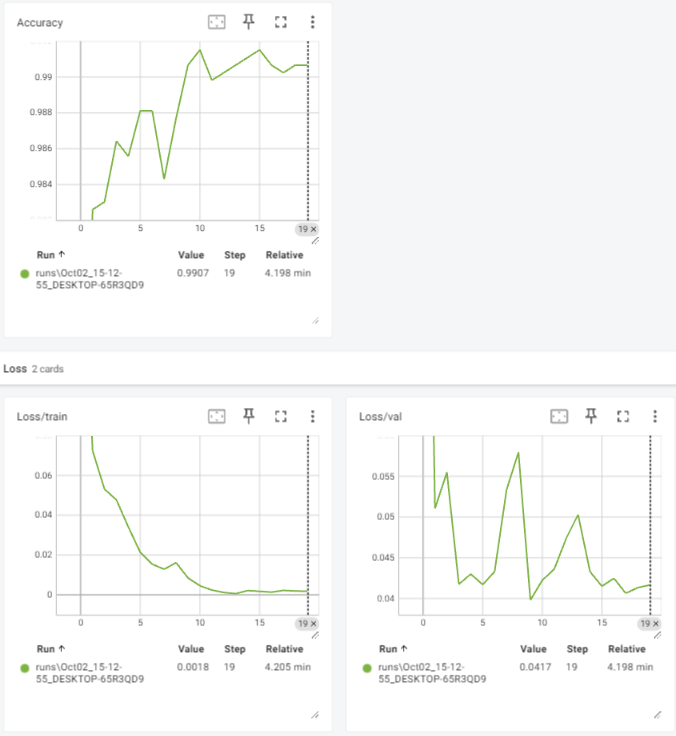